In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [3]:
train_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv', delimiter = ',')
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

test_passengers = test_data['PassengerId']

In [4]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# Simple data exploration

In [5]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
train_data.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# Encoded labeled data

In [7]:
def encode(df, isTest = False):
    df = df.replace({'CryoSleep':{False:0, True:1}, 
                 'VIP':{False:0,True:1}})
    if not isTest:
        df = df.replace({'Transported': {True:1, False:0}})
        df['Transported'] = df['Transported'].astype(float)
    
    df[['deck','cab_num','side']] = df.Cabin.str.split('/',expand=True)
    df[['grp_id','psg_grp_id']] = df.PassengerId.str.split('_',expand=True)
    df[['1st_name','surename']] = df.Name.str.split(' ',expand=True)
    
    le = LabelEncoder()
    df['HomePlanet'] = le.fit_transform(df['HomePlanet'])
    df['Destination'] = le.fit_transform(df['Destination'])
    df['surename'] = le.fit_transform(df['surename'])
    df['deck'] = le.fit_transform(df['deck'])
    df['cab_num'] = le.fit_transform(df['cab_num'])
    df['side'] = le.fit_transform(df['side'])
    
    df = df.drop(columns=['Cabin','Name'], axis=1)
    df['total_spent']=df['RoomService']+df['FoodCourt']+df['ShoppingMall']+df['Spa']+df['VRDeck']
    df[['cab_num','grp_id','psg_grp_id','CryoSleep','VIP']] = df[['cab_num','grp_id','psg_grp_id','CryoSleep','VIP']].astype(float)
    return df


In [8]:
encoded_train_data = encode(train_data)
encoded_test_data = encode(test_data, isTest = True)

In [9]:
encoded_train_data

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,cab_num,side,grp_id,psg_grp_id,1st_name,surename,total_spent
0,0001_01,1,0.0,2,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,1.0,1.0,Maham,1431,0.0
1,0002_01,0,0.0,2,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,5,0.0,1,2.0,1.0,Juanna,2109,736.0
2,0003_01,1,0.0,2,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0,0.0,1,3.0,1.0,Altark,1990,10383.0
3,0003_02,1,0.0,2,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0,0.0,1,3.0,2.0,Solam,1990,5176.0
4,0004_01,0,0.0,2,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,5,1.0,1,4.0,1.0,Willy,1778,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,1,0.0,0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0.0,0,1795.0,0,9276.0,1.0,Gravior,1416,8536.0
8689,9278_01,0,1.0,1,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,548.0,1,9278.0,1.0,Kurta,1341,0.0
8690,9279_01,0,0.0,2,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1.0,6,551.0,1,9279.0,1.0,Fayey,470,1873.0
8691,9280_01,1,0.0,0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,0.0,4,1385.0,1,9280.0,1.0,Celeon,996,4637.0


# Clean data

In [10]:
def clean(df):
    df = df.drop(columns=['PassengerId', '1st_name', 'grp_id','psg_grp_id', 'cab_num'])

    for i, cryos in df.CryoSleep.items():
        if cryos==1 and pd.isna(df.at[i, 'total_spent'])==True: 
            df.at[i, 'total_spent'] = 0
            df.at[i, 'RoomService'] = 0
            df.at[i, 'FoodCourt'] = 0
            df.at[i, 'ShoppingMall'] = 0
            df.at[i, 'Spa'] = 0
            df.at[i, 'VRDeck'] = 0
    return df

In [11]:
cleaned_train_data = clean(encoded_train_data)
cleaned_test_data = clean(encoded_test_data)

In [12]:
target_data = cleaned_train_data['Transported']
cleaned_train_data = cleaned_train_data.drop(columns = ['Transported'], axis = 1)

In [13]:
def handle_na(df, most_frequent = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side', 'surename']):
    mean_columns = [c for c in df.columns if c not in most_frequent]
    mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    freq_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    
    freq_imputer.fit(df[most_frequent])
    mean_imputer.fit(df[mean_columns])
    df[most_frequent] = freq_imputer.transform(df[most_frequent])
    df[mean_columns] = mean_imputer.transform(df[mean_columns])
    return df

In [14]:
imputed_train_data = handle_na(cleaned_train_data)
imputed_test_data = handle_na(cleaned_test_data)

In [15]:
imputed_train_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,side,surename,total_spent
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1431.0,0.0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,5.0,1.0,2109.0,736.0
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,1.0,1990.0,10383.0
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,1.0,1990.0,5176.0
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,5.0,1.0,1778.0,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1.0,0.0,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0.0,0.0,1416.0,8536.0
8689,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,1341.0,0.0
8690,0.0,0.0,2.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,6.0,1.0,470.0,1873.0
8691,1.0,0.0,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,4.0,1.0,996.0,4637.0


# Correlations

In [16]:
pd.concat([imputed_train_data, target_data], axis = 1).corr()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,side,surename,total_spent,Transported
HomePlanet,1.000000,0.080988,0.042618,0.123121,0.114819,0.192002,0.055581,0.088843,0.044439,0.034809,-0.347563,0.006099,0.002063,0.119875,0.107755
CryoSleep,0.080988,1.000000,-0.097877,-0.070736,-0.078281,-0.247485,-0.208749,-0.210621,-0.201137,-0.195655,0.023659,0.028419,0.008727,-0.384581,0.460132
Destination,0.042618,-0.097877,1.000000,-0.004207,-0.045351,0.044451,-0.109351,0.023006,-0.052634,-0.072775,0.166499,-0.015758,-0.015237,-0.089280,-0.104817
Age,0.123121,-0.070736,-0.004207,1.000000,0.091574,0.068384,0.127678,0.032889,0.121236,0.099382,-0.230152,0.011757,0.003068,0.178950,-0.074249
VIP,0.114819,-0.078281,-0.045351,0.091574,1.000000,0.056974,0.126094,0.018960,0.060663,0.123147,-0.168489,-0.006057,-0.004914,0.160388,-0.037261
RoomService,0.192002,-0.247485,0.044451,0.068384,0.056974,1.000000,-0.013972,0.054737,0.011326,-0.017836,-0.016364,0.000087,-0.012553,0.233222,-0.243313
FoodCourt,0.055581,-0.208749,-0.109351,0.127678,0.126094,-0.013972,1.000000,-0.012359,0.221653,0.225299,-0.303408,0.018190,0.011607,0.728152,0.044302
ShoppingMall,0.088843,-0.210621,0.023006,0.032889,0.018960,0.054737,-0.012359,1.000000,0.015145,-0.005843,-0.034297,-0.022681,0.006453,0.220486,0.007914
Spa,0.044439,-0.201137,-0.052634,0.121236,0.060663,0.011326,0.221653,0.015145,1.000000,0.148942,-0.202922,0.012365,0.001068,0.585334,-0.220071
VRDeck,0.034809,-0.195655,-0.072775,0.099382,0.123147,-0.017836,0.225299,-0.005843,0.148942,1.000000,-0.243203,-0.010172,0.011170,0.531589,-0.206112


# Normalize data

In [17]:
def normalize(df):
    scaler = StandardScaler()
    scaler.fit(X = df)
    df = scaler.transform(X = df)
    return df

In [18]:
normalized_train_data = normalize(cleaned_train_data)
normalized_test_data = normalize(cleaned_test_data)

In [19]:
normalized_train_data

array([[ 0.32524452, -0.73277002,  0.5770245 , ..., -0.99372894,
         0.44962228, -0.52483151],
       [-0.83303104, -0.73277002,  0.5770245 , ...,  0.84973791,
         1.48418197, -0.25304584],
       [ 0.32524452, -0.73277002,  0.5770245 , ...,  0.84973791,
         1.30259996,  3.30934057],
       ...,
       [-0.83303104, -0.73277002,  0.5770245 , ...,  0.84973791,
        -1.01676689,  0.16681872],
       [ 0.32524452, -0.73277002, -1.80364658, ...,  0.84973791,
        -0.21414389,  1.18749209],
       [ 0.32524452, -0.73277002,  0.5770245 , ...,  0.84973791,
        -0.21414389,  1.25728488]])

# ML model

In [20]:
def create_model(lr = 0.0001):
    
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(14,)),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    loss = "binary_crossentropy"
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(loss = loss,
                 optimizer = optimizer,
                 metrics = ['accuracy'])
    return model
    

In [21]:
model = create_model()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

history = model.fit(epochs = 100, x = normalized_train_data, y = target_data, validation_split = 0.2, callbacks=[lr_schedule])

Epoch 1/100
218/218 [==============================] - 2s 4ms/step - loss: 0.7017 - accuracy: 0.5279 - val_loss: 0.6568 - val_accuracy: 0.6377 - lr: 1.0000e-04
Epoch 2/100
218/218 [==============================] - 1s 3ms/step - loss: 0.6396 - accuracy: 0.6556 - val_loss: 0.5955 - val_accuracy: 0.7441 - lr: 1.1220e-04
Epoch 3/100
218/218 [==============================] - 1s 3ms/step - loss: 0.5880 - accuracy: 0.7209 - val_loss: 0.5388 - val_accuracy: 0.7729 - lr: 1.2589e-04
Epoch 4/100
218/218 [==============================] - 1s 3ms/step - loss: 0.5475 - accuracy: 0.7440 - val_loss: 0.4975 - val_accuracy: 0.7890 - lr: 1.4125e-04
Epoch 5/100
218/218 [==============================] - 1s 3ms/step - loss: 0.5159 - accuracy: 0.7601 - val_loss: 0.4718 - val_accuracy: 0.7941 - lr: 1.5849e-04
Epoch 6/100
218/218 [==============================] - 1s 4ms/step - loss: 0.4952 - accuracy: 0.7693 - val_loss: 0.4548 - val_accuracy: 0.7953 - lr: 1.7783e-04
Epoch 7/100
218/218 [===================

(0.0001, 10.0, 0.0, 10.0)

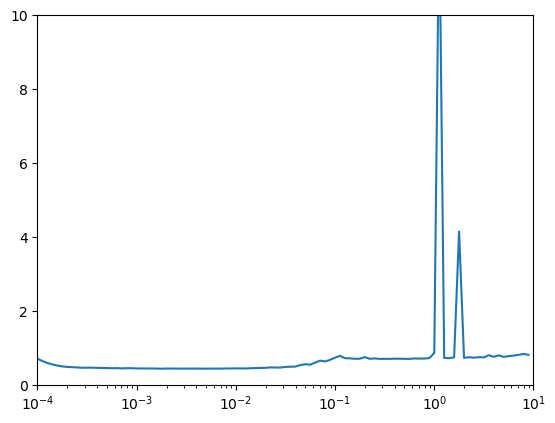

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [23]:
model = create_model(lr = 7e-3)

history = model.fit(epochs = 100, x = normalized_train_data, y = target_data, validation_split = 0.2)

Epoch 1/100
218/218 [==============================] - 2s 4ms/step - loss: 0.4836 - accuracy: 0.7693 - val_loss: 0.4369 - val_accuracy: 0.7993
Epoch 2/100
218/218 [==============================] - 1s 3ms/step - loss: 0.4543 - accuracy: 0.7876 - val_loss: 0.4363 - val_accuracy: 0.7907
Epoch 3/100
218/218 [==============================] - 1s 3ms/step - loss: 0.4512 - accuracy: 0.7909 - val_loss: 0.4336 - val_accuracy: 0.7936
Epoch 4/100
218/218 [==============================] - 1s 3ms/step - loss: 0.4491 - accuracy: 0.7949 - val_loss: 0.4320 - val_accuracy: 0.7953
Epoch 5/100
218/218 [==============================] - 1s 3ms/step - loss: 0.4462 - accuracy: 0.7939 - val_loss: 0.4045 - val_accuracy: 0.8022
Epoch 6/100
218/218 [==============================] - 1s 3ms/step - loss: 0.4427 - accuracy: 0.7955 - val_loss: 0.4142 - val_accuracy: 0.8016
Epoch 7/100
218/218 [==============================] - 1s 3ms/step - loss: 0.4414 - accuracy: 0.7984 - val_loss: 0.4382 - val_accuracy: 0.7930

In [24]:
res = model.predict(x = normalized_test_data)
predictions = []
for r in res:
    if r < 0.5:
        predictions.append(False)
    else:
        predictions.append(True)
predictions = pd.DataFrame(predictions, columns=['Transported'])
predictions = pd.concat([test_passengers, predictions], axis=1)

134/134 [==============================] - 0s 1ms/step


In [25]:
predictions.to_csv('/kaggle/working/submission.csv', index = False)